In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
from openslide import open_slide
import openslide
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
df_train = pd.read_csv('/kaggle/input/mayo-clinic-strip-ai/train.csv')
df_train.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


# Loading slide images

In [22]:
slide = open_slide('/kaggle/input/mayo-clinic-strip-ai/train/006388_0.tif')
slide_laa = open_slide('/kaggle/input/mayo-clinic-strip-ai/train/00c058_0.tif')

Open slide object not a numpy array

In [13]:
slide_properties = slide.properties
slide_properties

<_PropertyMap {'openslide.level-count': '1', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '60797', 'openslide.level[0].tile-height': '128', 'openslide.level[0].tile-width': '128', 'openslide.level[0].width': '34007', 'openslide.vendor': 'generic-tiff', 'tiff.ResolutionUnit': 'centimeter', 'tiff.XResolution': '10', 'tiff.YResolution': '10'}>

Image contains only 1 level

In [14]:
slide.level_dimensions

((34007, 60797),)

In [15]:
slide.level_downsamples

(1.0,)

The image was binned by a factor of one

In [16]:
#thumbnail = slide.get_thumbnail(size=(300, 300))
#thumbnail.show()

In [17]:
# plt.figure(figsize=(8, 8))
# plt.imshow(thumbnail)
# plt.show()  

In [18]:
#slide_np = np.array(thumbnail)

In [19]:
# plt.figure(figsize=(8, 8))
# plt.imshow(slide_np)

To read the info of a certain region in the slide, we need to specify from which level we intend to read the data

In [20]:
size = (10000, 10000)
level_img = slide.read_region((0,0), 0, size)
level_img_color = level_img.convert('RGB')

In [23]:
level_img_laa = slide_laa.read_region((0,0), 0, size)
level_img_color_laa = level_img_laa.convert('RGB')

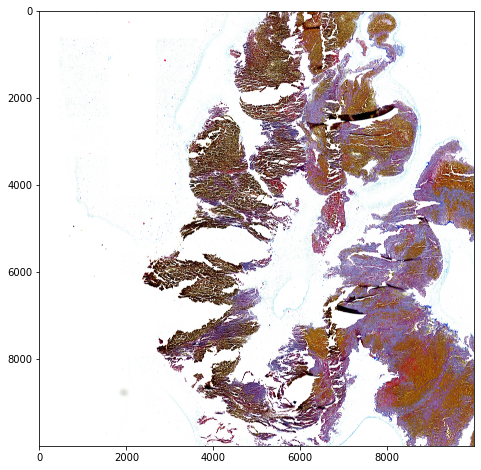

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(level_img_color)
plt.show() 

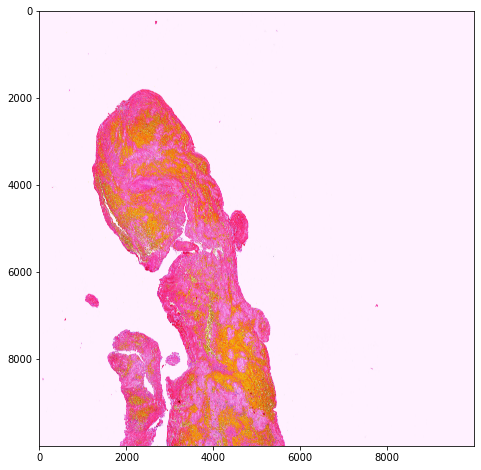

In [24]:
plt.figure(figsize=(8, 8))
plt.imshow(level_img_color_laa)
plt.show() 